In [472]:
!git clone https://github.com/jksingh07/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [473]:
!ls Track

driving_log.csv  IMG


In [474]:
!pip install imgaug

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam
import cv2
import pandas as pd
import random
import os
from imgaug import augmenters as iaa
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Reading The Data using PANDAS **

In [476]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\center_2019_02_22_23_20_35_231.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\left_2019_02_22_23_20_35_231.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\right_2019_02_22_23_20_35_231.jpg,0.0,0.0,0.0,0.000079
1,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\center_2019_02_22_23_20_35_364.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\left_2019_02_22_23_20_35_364.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\right_2019_02_22_23_20_35_364.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\center_2019_02_22_23_20_35_469.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\left_2019_02_22_23_20_35_469.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\right_2019_02_22_23_20_35_469.jpg,0.0,0.0,0.0,0.000078
3,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\center_2019_02_22_23_20_35_577.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\left_2019_02_22_23_20_35_577.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\right_2019_02_22_23_20_35_577.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\center_2019_02_22_23_20_35_682.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\left_2019_02_22_23_20_35_682.jpg,C:\Users\Lenovo\Desktop\Projects\Self Driving Car\Data\IMG\right_2019_02_22_23_20_35_682.jpg,0.0,0.0,0.0,0.000081


Removing The Extra Path JUST KEEP IMAGE NAME this is done by using library **ntpath**

In [477]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_02_22_23_20_35_231.jpg,left_2019_02_22_23_20_35_231.jpg,right_2019_02_22_23_20_35_231.jpg,0.0,0.0,0.0,0.000079
1,center_2019_02_22_23_20_35_364.jpg,left_2019_02_22_23_20_35_364.jpg,right_2019_02_22_23_20_35_364.jpg,0.0,0.0,0.0,0.000078
2,center_2019_02_22_23_20_35_469.jpg,left_2019_02_22_23_20_35_469.jpg,right_2019_02_22_23_20_35_469.jpg,0.0,0.0,0.0,0.000078
3,center_2019_02_22_23_20_35_577.jpg,left_2019_02_22_23_20_35_577.jpg,right_2019_02_22_23_20_35_577.jpg,0.0,0.0,0.0,0.000078
4,center_2019_02_22_23_20_35_682.jpg,left_2019_02_22_23_20_35_682.jpg,right_2019_02_22_23_20_35_682.jpg,0.0,0.0,0.0,0.000081


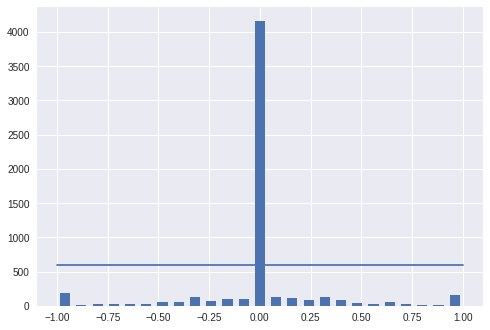

In [478]:
num_bins = 25
samples_per_bin = 600
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
#print(bins,center)

plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [479]:
print('Total Data: ',len(data))
remove_list = []
for i in range(num_bins):
  list_ = []
  for j in range(len(data['steering'])):
    if(data['steering'][j]>=bins[i] and data['steering'][j]<=bins[i+1]):
      list_.append(j)
  list_ = shuffle(list_)
  remove_list.extend(list_[samples_per_bin:])
  
print("Removed data : ",len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining data : ',len(data))

Total Data:  5806
Removed data :  3560
Remaining data :  2246


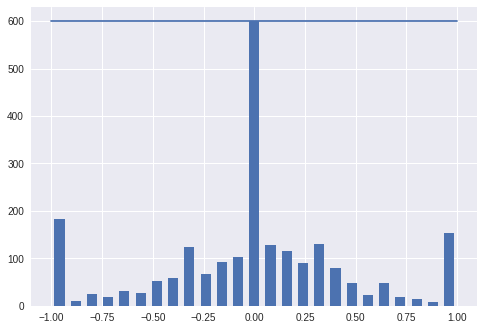

In [480]:
hist,_ = np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
  image_path=[]
  steering=[]
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering

image_paths, steerings = load_img_steering(datadir+'/IMG', data)

In [482]:
X_train,X_valid,y_train,y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print("Training samples : ",len(X_train))
print("Validation samples : ",len(X_valid))

Training samples :  1796
Validation samples :  450


In [483]:
y_train


array([ 0.07863741,  0.1946214 ,  0.        , ..., -0.7187179 ,
        0.1262863 , -0.1106001 ])

Text(0.5, 1.0, 'Validation Set')

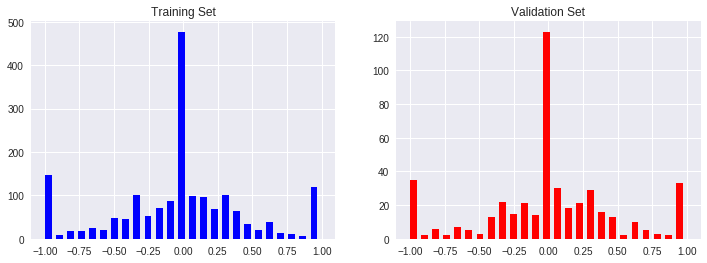

In [484]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train,bins=num_bins,width=0.05,color='b')
axs[0].set_title('Training Set')
axs[1].hist(y_valid,bins=num_bins,width=0.05,color='r')
axs[1].set_title('Validation Set')

In [0]:
def img_preprocessing(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

Functions for Augmenting Image(zoom, translation, brightness, flip and so on) to create a variety in the dataset

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Choosing a random augumenting function

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

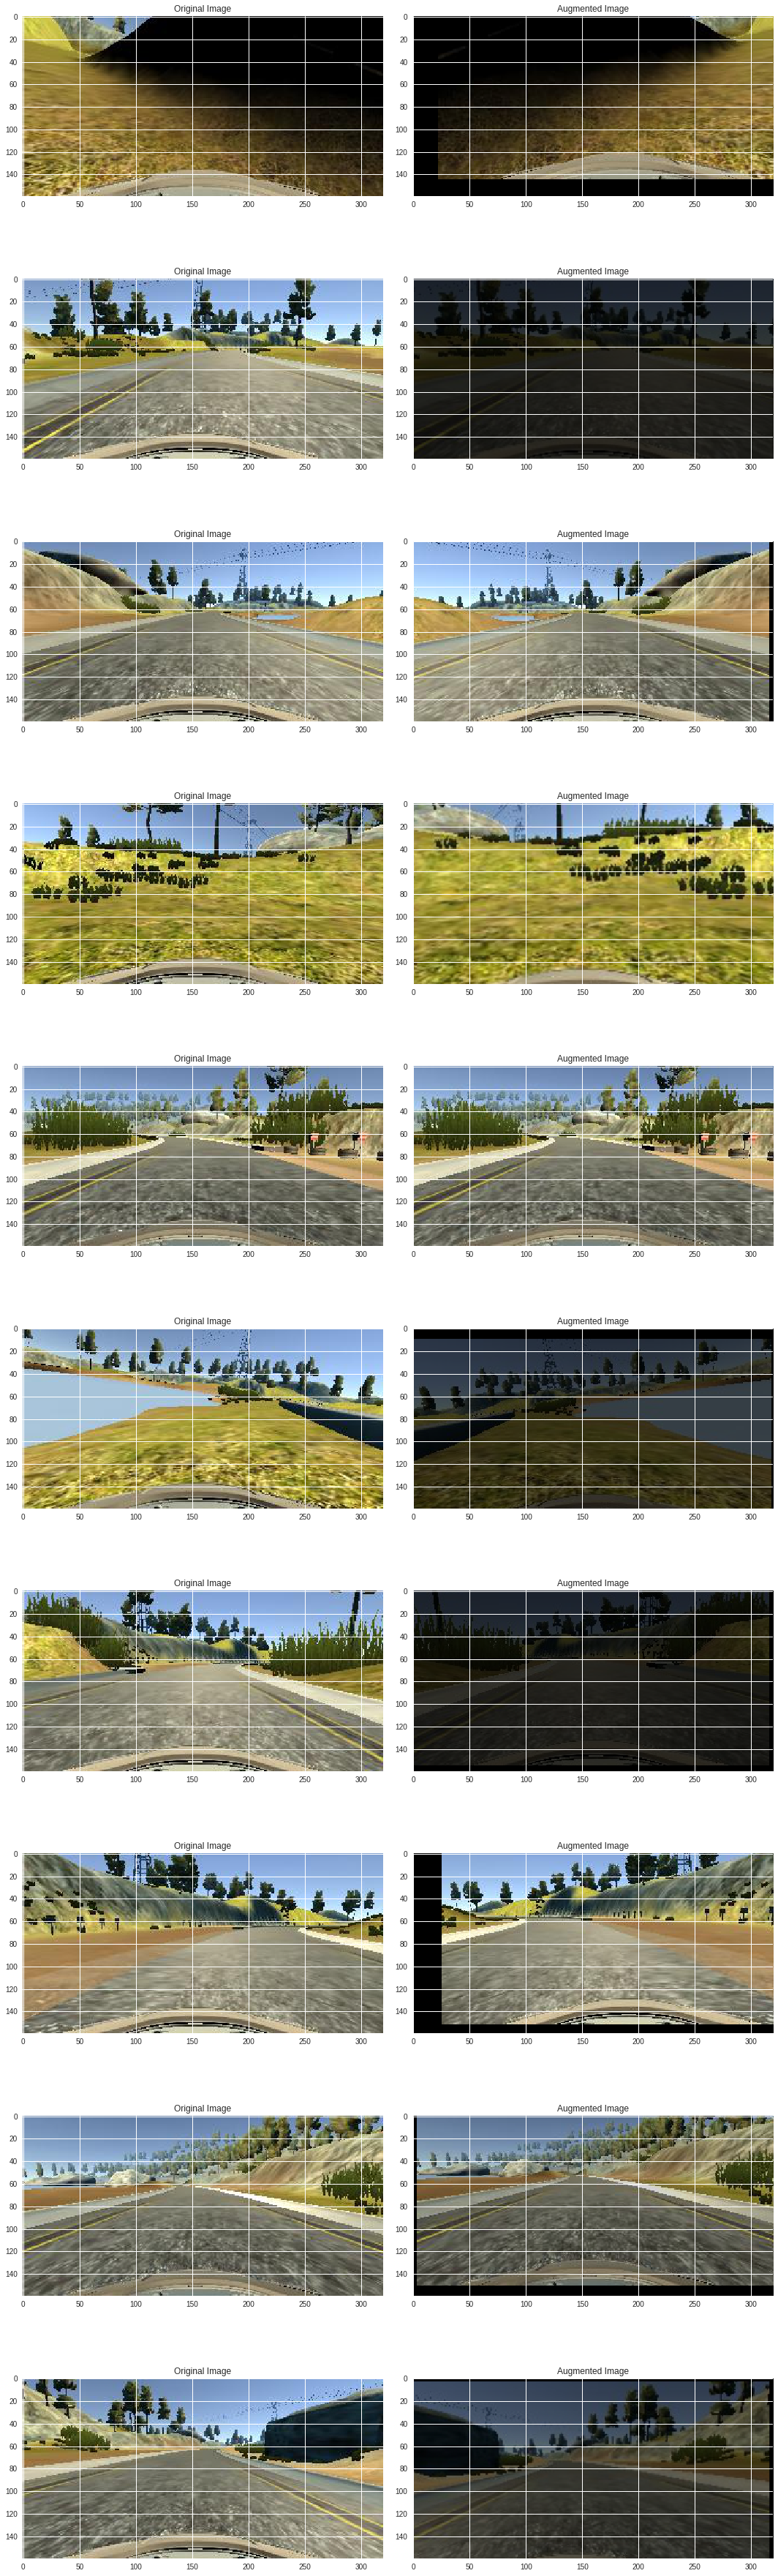

In [488]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steer = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")


Batch Generator For making generating augumented images

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

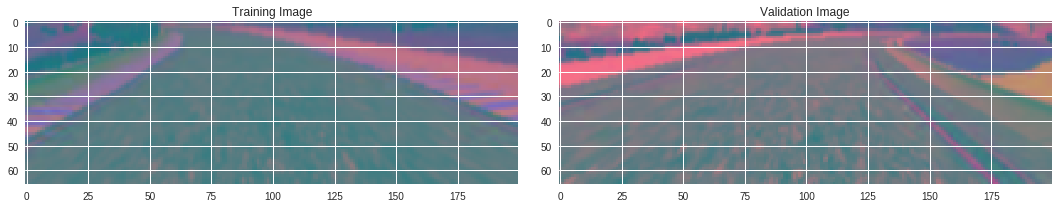

In [490]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Forming a CNN , **Nvidia model**

In [0]:
def nvidia_model():
  model  = Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='elu'))# elu activation works similar to relu but it do not assign 0 to negative values rather than just assign a negative constant
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  model.compile(Adam(lr=1e-4),loss='mse')
  return model

In [492]:
model = nvidia_model()
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_301 (Conv2D)          (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_59 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_234 (Dense)            (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

Fit Generator

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 177s 591ms/step - loss: 0.2338 - val_loss: 0.2325
Epoch 2/10
300/300 [==============================] - 161s 538ms/step - loss: 0.2246 - val_loss: 0.2357
Epoch 3/10
246/300 [=======================>......] - ETA: 20s - loss: 0.2184

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','validation'])
plt.title('Loss')
plt.show()

In [0]:
model.save('model.h5')

In [0]:
from google.colab  import files
files.download('model.h5')